Final Project 
======

Kaggle Competition 
-----

For this project I chose to do the active competition [San Francisco Crime Classification](https://www.kaggle.com/c/sf-crime/). I'll test out a number of different algorithms with test data. I am interested in this type of analysis as it is data science that contributes to the common good.

### Setup

In [1]:
# Pandas and numpy
import pandas as pd
import numpy as np

# Python functions
from dateutil.relativedelta import *
from datetime import datetime
import re, math

# Patsy 
from patsy import dmatrices

# sklearn functions
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import OneHotEncoder, Imputer, Normalizer
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report\
                        , f1_score, accuracy_score 
from sklearn.feature_selection import SelectKBest\
                        , SelectPercentile, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.decomposition import PCA\
                                , TruncatedSVD  #for sparse matrices
from sklearn.cluster import KMeans
from sklearn.grid_search import GridSearchCV 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import AdaBoostClassifier

# matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

# Make plots BIG
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 12, 8

# GIS functionality
from mpl_toolkits.basemap import Basemap, cm
import cartopy.io.shapereader as shpreader
import fiona
import pysal 
from pyproj import Proj
from pysal.cg.shapes import Point
from pysal.cg.locators import PolygonLocator, PointLocator, BruteForcePointLocator 
from pysal.cg.sphere import arcdist

# Multiprocessing 
import multiprocessing

# Logging
import logging
FORMAT = '%(asctime)-15s %(message)s'
logging.basicConfig(format=FORMAT)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
class MultiColumnLabelEncoder:
    ''' Create a class that encodes
        labels for a matrix of data
    '''
    def __init__(self, columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here
    
    def get_params(self, deep=True):
        out = dict()
        if self.columns: out['columns'] = columns
        return out

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). 
        '''
        numerics = [np.float16, np.float32, np.float64]
        ints = [np.int16, np.int32, np.int64]
        output = X.copy()
        '''
        if self.columns is not None:
            for col in self.columns:
                if col.dtype not in numerics+ints:
                    output[col] = LabelEncoder().fit_transform(output[col])
                elif col.dtype not in ints:
                    output[col] = scale(output[col])
        else:
        '''
        try:
            for colname,col in output.iteritems():
                if col.dtype not in numerics+ints:
                    # Turn text columns into ints
                    output[colname] = LabelEncoder().fit_transform(output[colname])
                elif col.dtype in numerics:
                    # handle floats with scaling
                    output[colname] = scale(output[colname])
                elif col.dtype in ints:
                    pass # leave integers alone
        except:
            output = LabelEncoder().fit_transform(output)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [40]:
train_raw = pd.read_csv('Data/train.csv')
test_raw = pd.read_csv('Data/test.csv')
sample_submission = pd.read_csv('Data/sampleSubmission.csv')
print train_raw.shape

(878049, 9)


### Part 1: Submit first (bad) try

In [4]:
test_raw.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [5]:
sample_submission.head()

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [6]:
train_data\
,train_labels = train_raw[['DayOfWeek'\
                                     ,'PdDistrict'\
                                     ,'Address'\
                                     ,'X'\
                                     ,'Y']][2001:]\
                            ,train_raw['Category'][2001:]
dev_data\
,dev_labels = train_raw[['DayOfWeek'\
                                 ,'PdDistrict'\
                                 ,'Address'\
                                 ,'X'\
                                 ,'Y']][:1000]\
                            ,train_raw['Category'][:1000]
dev_test_data\
,dev_test_labels = train_raw[['DayOfWeek'\
                                 ,'PdDistrict'\
                                 ,'Address'\
                                 ,'X'\
                                 ,'Y']][1001:2000]\
                            ,train_raw['Category'][1001:2000]
test_data = test_raw[['DayOfWeek'\
                     ,'PdDistrict'\
                     ,'Address'\
                     ,'X'\
                     ,'Y']]

In [7]:
rf = RandomForestClassifier() #leaving with default settings for now

##### Data needs to be preprocessed for RF in sklearn

In [8]:
def recode(df):
    numerics = ['float16', 'float32', 'float64']
    ints = ['int16', 'int32', 'int64']
    for i in range(df.shape[1]):
        t = df.iloc[:,i].dtype
        if t not in numerics or ints:
            le = LabelEncoder()
            le.fit(df.iloc[:,i])
            df.iloc[:,i] = le.transform(df.iloc[:,i])
        elif t not in ints:
            df.iloc[:,i] = scale(df.iloc[:,i])
    return df

def recode_labels(df):
    le = LabelEncoder()
    le.fit(df)
    return le

In [9]:
dev_data = recode(dev_data)
dev_label_le = recode_labels(np.concatenate((dev_labels,dev_test_labels),axis=1))
dev_labels = dev_label_le.transform(dev_labels)
dev_test_data = recode(dev_test_data)
dev_test_labels = dev_label_le.transform(dev_test_labels)

##### Run model

In [10]:
rf.fit(dev_data,dev_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [11]:
predictions = rf.predict(dev_test_data)

In [12]:
actual_predictions = dev_label_le.inverse_transform(predictions)
actual_labels = dev_label_le.inverse_transform(dev_test_labels)
print actual_predictions[:5],'\n',actual_labels[:5]

['LARCENY/THEFT' 'LARCENY/THEFT' 'LARCENY/THEFT' 'VEHICLE THEFT'
 'VEHICLE THEFT'] 
['OTHER OFFENSES' 'LARCENY/THEFT' 'LARCENY/THEFT' 'WARRANTS' 'WARRANTS']


In [13]:
accuracy = np.sum((actual_predictions == actual_labels)*1.0)/len(dev_labels)
print 'Dev Accuracy: {0}%'.format(accuracy*100)

Dev Accuracy: 20.2%


##### Train with real data

In [14]:
train_data, test_data = recode(train_data), recode(test_data)
train_le = recode_labels(train_labels)
train_labels = train_le.transform(train_labels)

/Library/Python/2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [15]:
rf = RandomForestClassifier()
rf.fit(train_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

##### Make predictions and format for submission

In [16]:
predictions = rf.predict(test_data)
actual_predictions = train_le.inverse_transform(predictions)

In [17]:
l = len(test_data)
submission = np.zeros((l,40),dtype=np.int32)
submission[:,0] = range(l)
cols = train_le.classes_ 
for i,c in enumerate(cols):
    submission[:,i+1] = actual_predictions == c

In [18]:
submission_cols = ['Id']
submission_cols.extend(cols)
submission_df = pd.DataFrame(submission,columns=submission_cols)
submission_df.head()

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Save data to csv file for submission

In [19]:
submission_df.to_csv('Data/submission_file1.csv',index=False)

First attempt: Rank 208, score 26.95890, tested accuracy of ~20%.

#### Analyze errors

In [20]:
dev_test_data\
,dev_test_labels = train_raw[['DayOfWeek'\
                                 ,'PdDistrict'\
                                 ,'Address'\
                                 ,'X'\
                                 ,'Y']][1001:2000]\
                            ,train_raw['Category'][1001:2000]
dev_test_data = recode(dev_test_data)
predictions = rf.predict(dev_test_data)
actual_predictions = train_le.inverse_transform(predictions)

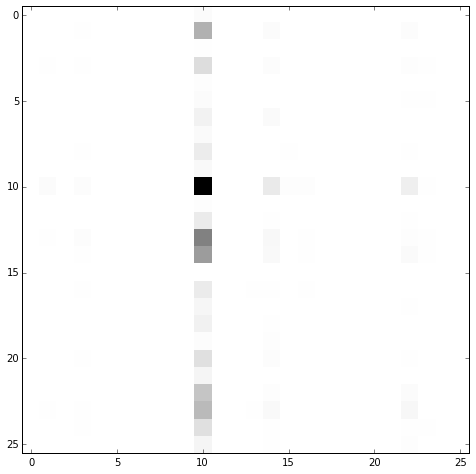

In [21]:
conf = confusion_matrix(dev_test_labels,actual_predictions)
plt.imshow(conf, cmap='binary',interpolation='nearest')

In [22]:
pd.crosstab(dev_test_labels, actual_predictions, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,ASSAULT,BURGLARY,LARCENY/THEFT,NON-CRIMINAL,OTHER OFFENSES,RECOVERED VEHICLE,ROBBERY,VANDALISM,VEHICLE THEFT,All
True,,,,,,,,,,
ARSON,0,0,4,0,0,0,0,0,0,4
ASSAULT,0,1,71,0,4,0,0,3,0,79
BRIBERY,0,0,1,0,0,0,0,0,0,1
BURGLARY,1,1,31,0,3,0,0,2,1,39
DISORDERLY CONDUCT,0,0,2,0,0,0,0,0,0,2
DRIVING UNDER THE INFLUENCE,0,0,4,0,0,0,0,1,1,6
DRUG/NARCOTIC,0,0,12,0,5,0,0,0,0,17
DRUNKENNESS,0,0,5,0,0,0,0,0,0,5
FRAUD,0,1,18,0,0,1,0,1,0,21


Since samples are not weighted well in terms of categories, the model seems to be having difficulties with categories that have a larger amount of observations - likely because all of the conditions used to predict crimes are seen more frequently for the samples with more observations. For example, there is no predictions that are Liqour Law because this is an infrequent category in the training data. To make the model generalize better it will be necessary to resample the dataset so that possible outcomes are represented more evenly. 

### Part 2: Tests to increase accuracy

##### Reload data

In [47]:
logger.info('Load of data started')
train_raw = pd.read_csv('Data/train.csv')
test_raw = pd.read_csv('Data/test.csv')
sample_submission = pd.read_csv('Data/sampleSubmission.csv')
logger.info('Load of data finished')
print train_raw.shape

INFO:root:Load of data started
INFO:root:Load of data finished


(878049, 9)


##### Deep dive into crimes dataset

In [48]:
print train_raw.groupby(['Category']).size()

Category
ARSON                            1513
ASSAULT                         76876
BAD CHECKS                        406
BRIBERY                           289
BURGLARY                        36755
DISORDERLY CONDUCT               4320
DRIVING UNDER THE INFLUENCE      2268
DRUG/NARCOTIC                   53971
DRUNKENNESS                      4280
EMBEZZLEMENT                     1166
EXTORTION                         256
FAMILY OFFENSES                   491
FORGERY/COUNTERFEITING          10609
FRAUD                           16679
GAMBLING                          146
KIDNAPPING                       2341
LARCENY/THEFT                  174900
LIQUOR LAWS                      1903
LOITERING                        1225
MISSING PERSON                  25989
NON-CRIMINAL                    92304
OTHER OFFENSES                 126182
PORNOGRAPHY/OBSCENE MAT            22
PROSTITUTION                     7484
RECOVERED VEHICLE                3138
ROBBERY                         23000
RUN

In [49]:
def show_descripts(cat,first_n=10):
    ''' A function to evaluate descriptions for a category 
        sorted by the number of crimes
    '''
    g = train_raw[train_raw['Category']==cat]\
        [['Category','Descript']]\
        .groupby(['Category','Descript']).agg(len)
    for x in sorted(zip(g.index,g.values),key=lambda x: x[1], reverse=True)[:first_n]:
        print x

show_descripts('SUSPICIOUS OCC')

(('SUSPICIOUS OCC', 'SUSPICIOUS OCCURRENCE'), 21891)
(('SUSPICIOUS OCC', 'INVESTIGATIVE DETENTION'), 5822)
(('SUSPICIOUS OCC', 'SUSPICIOUS PERSON'), 1943)
(('SUSPICIOUS OCC', 'SUSPICIOUS ACT TOWARDS FEMALE'), 757)
(('SUSPICIOUS OCC', 'SUSPICIOUS OCCURRENCE, POSSIBLE SHOTS FIRED'), 389)
(('SUSPICIOUS OCC', 'SUSPICIOUS ACT TOWARDS CHILD'), 273)
(('SUSPICIOUS OCC', 'UNUSUAL OCCURENCE'), 173)
(('SUSPICIOUS OCC', 'SUSPICIOUS AUTO, POSSIBLY SEX'), 166)


I've noticed that categories aren't the best at describing the data in terms a model would understand. Some categories have a lot of crimes included that would make it difficult to have an accurate model, no matter what supplemental data sources are attached to the training set. Below I am looking to create a smaller number of 'meta-categories' that will be easier to predict by grouping individual categories and by including individual descriptions into appropriate meta-categories that will be easier for a model to interpret. 

After re-classifying the crimes for the training set, I will attempt to build a prediction model that will be used to predict meta-categories for the test set - which will then be utilized as an additional feature in the final model.

In [50]:
def collar_crimes(x,y):
    ''' Add a meta category for 
        crimes based on the skills
        required
    '''
    blue_collar_violent = [ 
                   "ASSAULT"
                   , "KIDNAPPING"
                   , "ARSON"
                   , 'DOMESTIC VIOLENCE'
                   , 'GANG ACTIVITY'
                  ]
    blue_collar_other = [
                "VANDALISM"
                ,"DISORDERLY CONDUCT"
                ,"TRESPASS"
                ,'TREA'
               , 'LOITERING'
                ,'RESISTING ARREST'
                ,'PROBATION VIOLATION'
                ,'PROBATION VIOLATION'
                ,'VIOLATION OF RESTRAINING ORDER'
                ,'PAROLE VIOLATION'
    ]
    sex_crimes = [
            'SEX OFFENSES FORCIBLE',
            'PORNOGRAPHY/OBSCENE MAT',
            'SEX OFFENSES NON FORCIBLE',
            'PROSTITUTION'
        ]
    alcohol = [
        'DRIVING UNDER THE INFLUENCE',
        'DRUNKENNESS',
        'LIQUOR LAWS'
    ]
    drug = ['DRUG/NARCOTIC']
    theft = [
        'LARCENY/THEFT',
         'STOLEN PROPERTY',
         "ROBBERY",
         'CREDIT CARD, THEFT BY USE OF',
        'FRAUDULENT USE OF AUTOMATED TELLER CARD',
        'BURGLARY'
    ]
    vehicle = [
        'RECOVERED VEHICLE',
        'VEHICLE THEFT',
        'DRIVERS LICENSE, SUSPENDED OR REVOKED',
        'TRAFFIC VIOLATION',
        'TRAFFIC VIOLATION ARREST',
        'DRIVERS LICENSE, SUSPENDED OR REVOKED',
        'LOST/STOLEN LICENSE PLATE',
        'IMPOUNDED VEHICLE',
        'TRAFFIC ACCIDENT',
        'MALICIOUS MISCHIEF, VANDALISM OF VEHICLES'
    ]
    noncrime = [
        'MISSING PERSON',
        'RUNAWAY',
        'SUICIDE',
        'NON-CRIMINAL',
        'SUSPICIOUS OCC'
    ]
    white_collar = [ 
        "FRAUD"
       , "FORGERY/COUNTERFEITING"
       , "BAD CHECKS" 
       , "EXTORTION"
       , "EMBEZZLEMENT"
       , "BRIBERY"
        , 'CONSPIRACY'
    ]
    if x in blue_collar_violent or y in blue_collar_violent: return 1
    elif x in sex_crimes or y in sex_crimes: return 2
    elif x in alcohol or y in alcohol: return 3
    elif x in drug or y in drug: return 4
    elif x in theft or y in theft: return 5
    elif x in vehicle or y in vehicle: return 6
    elif x in noncrime or y in noncrime: return 7
    elif x in white_collar or y in white_collar: return 8
    elif x in blue_collar_other or y in blue_collar_other: return 9
    else: return 10
collar_crimes = np.vectorize(collar_crimes,otypes=[np.int64])
logger.info('Creation of collar_id started')
train_raw['collar_id'] = collar_crimes(train_raw['Category'],train_raw['Descript'])
logger.info('Creation of collar_id ended')

INFO:root:Creation of collar_id started
INFO:root:Creation of collar_id ended


In [51]:
def show_newcategories(col,first_n=10):
    ''' Evaluate how crimes are fit into the new 
        categories defined above
    '''
    g = train_raw[train_raw['collar_id']==col]\
        [['Category','Descript']]\
        .groupby(['Category','Descript']).agg(len)
    for x in sorted(zip(g.index,g.values),key=lambda x: x[1], reverse=True)[:first_n]:
        print x

show_newcategories(1)

(('ASSAULT', 'BATTERY'), 27441)
(('ASSAULT', 'THREATS AGAINST LIFE'), 14716)
(('SECONDARY CODES', 'DOMESTIC VIOLENCE'), 7449)
(('ASSAULT', 'INFLICT INJURY ON COHABITEE'), 7122)
(('ASSAULT', 'AGGRAVATED ASSAULT WITH A DEADLY WEAPON'), 6451)
(('ASSAULT', 'AGGRAVATED ASSAULT WITH BODILY FORCE'), 4898)
(('ASSAULT', 'BATTERY, FORMER SPOUSE OR DATING RELATIONSHIP'), 2712)
(('ASSAULT', 'AGGRAVATED ASSAULT WITH A KNIFE'), 2442)
(('KIDNAPPING', 'FALSE IMPRISONMENT'), 1410)
(('ASSAULT', 'BATTERY OF A POLICE OFFICER'), 1331)


Another thing I've noticed is how some categories have minimal amounts of crimes which makes it difficult to build a model because there is such a strong bias in predicting crimes that occur the most often. I am creating a sampling methodology that samples with replacement in order to gather a more even amount of observations in each dataset.  

In [52]:
# Gather counts of each category 
g = train_raw[['Category','Descript']].groupby(['Category']).agg(len)
group_cnts = pd.DataFrame({'Category':np.array(g.index).T,'Value':np.array(g.T)[0]})
print group_cnts

                       Category   Value
0                         ARSON    1513
1                       ASSAULT   76876
2                    BAD CHECKS     406
3                       BRIBERY     289
4                      BURGLARY   36755
5            DISORDERLY CONDUCT    4320
6   DRIVING UNDER THE INFLUENCE    2268
7                 DRUG/NARCOTIC   53971
8                   DRUNKENNESS    4280
9                  EMBEZZLEMENT    1166
10                    EXTORTION     256
11              FAMILY OFFENSES     491
12       FORGERY/COUNTERFEITING   10609
13                        FRAUD   16679
14                     GAMBLING     146
15                   KIDNAPPING    2341
16                LARCENY/THEFT  174900
17                  LIQUOR LAWS    1903
18                    LOITERING    1225
19               MISSING PERSON   25989
20                 NON-CRIMINAL   92304
21               OTHER OFFENSES  126182
22      PORNOGRAPHY/OBSCENE MAT      22
23                 PROSTITUTION    7484


In [53]:
def sample_df(df,group_name,groups,group_n,\
              group_cnts,nX=10):
    ''' Do sampling manually with 
        even group size 
        
        Keeps nX times as many observations
        as the original counts, or as many 
        new samples with replacement until
        group_n is reached (whichever is 
        the lower amount).
    '''
    x = df.copy()
    out = []
    for g in groups:
        try:
            # Replace only when necessary
            out.append(x[x[group_name]==g].\
                   sample(group_n,replace=False))
        except:
            i = len(x[x[group_name]==g])
            n = group_cnts[group_cnts.iloc[:,0]\
                           ==g].iloc[0,1]
            out.append(x[x[group_name]==g])
            out.append(x[x[group_name]==g]\
                   .sample(min([group_n-i,n*(nX-1)])\
                           ,replace=True))
    out_df = pd.concat(out)
    s = out_df.sample(group_n*len(groups)\
                      ,replace=True)
    return s

##### Add time of day 

Since a timestamp is not good for the generalization of the model, attempt bucketing of hours within each day, and break off day of month and year of crime and separate dimensions. 

In [54]:
ceil = np.vectorize(math.ceil)
    
logger.info('Datetime conversion started')
train_raw['Dates'] = pd.to_datetime(train_raw['Dates'])
test_raw['Dates'] = pd.to_datetime(test_raw['Dates'])

logger.info('DaySegment creation started')
train_raw['DaySegment'] = ceil((train_raw['Dates'].dt.hour+1)/4).astype(np.int)
test_raw['DaySegment'] = ceil((test_raw['Dates'].dt.hour+1)/4).astype(np.int)

logger.info('TimeOfDay creation started')
train_raw['TimeOfDay'] = train_raw['Dates'].dt.hour
test_raw['TimeOfDay'] = test_raw['Dates'].dt.hour

logger.info('DayOfMonth creation started')
train_raw['DayOfMonth'] = train_raw['Dates'].dt.day
test_raw['DayOfMonth'] = test_raw['Dates'].dt.day

logger.info('Year creation started')
train_raw['Year'] = train_raw['Dates'].dt.year
test_raw['Year'] = test_raw['Dates'].dt.year

logger.info('Month creation started')
train_raw['Month'] = train_raw['Dates'].dt.month
test_raw['Month'] = test_raw['Dates'].dt.month

logger.info('YearQtr creation started')
train_raw['YearQtr'] = train_raw['Dates'].dt.year*100\
    +ceil(train_raw['Dates'].dt.month/4).astype(np.int)
test_raw['YearQtr'] = test_raw['Dates'].dt.year*100\
    +ceil(test_raw['Dates'].dt.month/4).astype(np.int)

logger.info('YearSegment creation started')
train_raw['YearSegment'] = ceil(train_raw['Dates'].dt.month/4).astype(np.int)
test_raw['YearSegment'] =  ceil(test_raw['Dates'].dt.month/4).astype(np.int)
logger.info('Date feature processing ended')

INFO:root:Datetime conversion started
INFO:root:DaySegment creation started
INFO:root:TimeOfDay creation started
INFO:root:DayOfMonth creation started
INFO:root:Year creation started
INFO:root:Month creation started
INFO:root:YearQtr creation started
INFO:root:YearSegment creation started
INFO:root:Date feature processing ended


##### Add clustering based on lat/lon and time of day

Currently, by using the exact location of the crime, the model does not generalize very well. I KMeans to segment training data into clusters based on location, time of day, and year and add both the cluster label and distance from centroid as features.

In [55]:
def test_clusters(range_n_clusters,fields=['X','Y','YearSegment','Year']):
    km_models = []
    i_scores = []
    tr = train_raw[fields].copy()
    tr = le.fit_transform(tr)
    for n_clusters in range(range_n_clusters):
        logger.info('Cluster {} started'.format(n_clusters))
        if n_clusters>1:
            km = KMeans(n_clusters=n_clusters, random_state=5)
            km.fit(tr)
            km_models.append(km)
            inertia = km.inertia_ 
            print 'For {0}, inertia = {1}'.format(
                n_clusters, inertia
            )
            i_scores.append(inertia)
       
    # plot results
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title('KMeans inertia values')
    ax.set_xlabel('Clusters')
    ax.set_ylabel('Inertia')
    ax.plot([i for i in range(range_n_clusters) \
             if i>1],i_scores,'-', linewidth=2)
    plt.show()
    
#test_clusters(25)

Because of the clustering process, I found that there are a few points with what must be default values of lat/lon coordinates: 90,-120.5. Those are values that aren't interpretable by GIS packages and cause significant issues with clustering as well, so I have to manually impute them with better default values here.

In [56]:
# Manually impute bad X,Y values as 
train_raw.loc[train_raw['X']==-120.5,['X']] = np.mean(train_raw['X'])
train_raw.loc[train_raw['Y']==90,['Y']] = np.mean(train_raw['Y'])

In [57]:
# Reload data in case of changes
logger.info('Clustering started')
le = MultiColumnLabelEncoder()
nrm = Normalizer()
tr = train_raw[['X','Y','TimeOfDay','YearQtr']].copy()
pl = Pipeline([('le',le),('nrm',nrm)])
tr = pl.fit_transform(tr)

# Set k
k = 20

# Initialize Kmeans model
km = KMeans(n_clusters=k)
logger.info('Clustering training data')
train_raw['KMcluster'] = km.fit_predict(tr)

# Calculate distances
logger.info('Clustering distance calculation for training data')
distances = km.transform(tr)
train_raw['KMdistance'] = np.min(distances,axis=1)

# Predict for test dataset
logger.info('Clustering training data')
tr = test_raw[['X','Y','TimeOfDay','YearQtr']].copy()
tr = le.transform(tr)
test_raw['KMcluster'] = km.predict(tr)
logger.info('Clustering distance calculation for training data')
distances = km.transform(tr)
test_raw['KMdistance'] = np.min(distances,axis=1)
logger.info('Clustering finished')

INFO:root:Clustering started
INFO:root:Clustering training data
INFO:root:Clustering distance calculation for training data
INFO:root:Clustering training data
INFO:root:Clustering distance calculation for training data
INFO:root:Clustering finished


In [58]:
def show_clustercat(cluster):
    ''' A function that shows top crimes in each cluster '''
    g = train_raw[train_raw['KMcluster']==cluster].\
        groupby(['Category','KMcluster'])['Category'].agg(len)
    for x in sorted(zip(g.index,g.values),key=lambda x: \
                    (x[0][1],x[1]), reverse=True)[:10]:
        print x
    
show_clustercat(11)

(('OTHER OFFENSES', 11), 5849)
(('ASSAULT', 11), 5594)
(('LARCENY/THEFT', 11), 5225)
(('NON-CRIMINAL', 11), 3580)
(('VANDALISM', 11), 3105)
(('ROBBERY', 11), 2526)
(('BURGLARY', 11), 2308)
(('WARRANTS', 11), 2105)
(('VEHICLE THEFT', 11), 1869)
(('DRUG/NARCOTIC', 11), 1639)


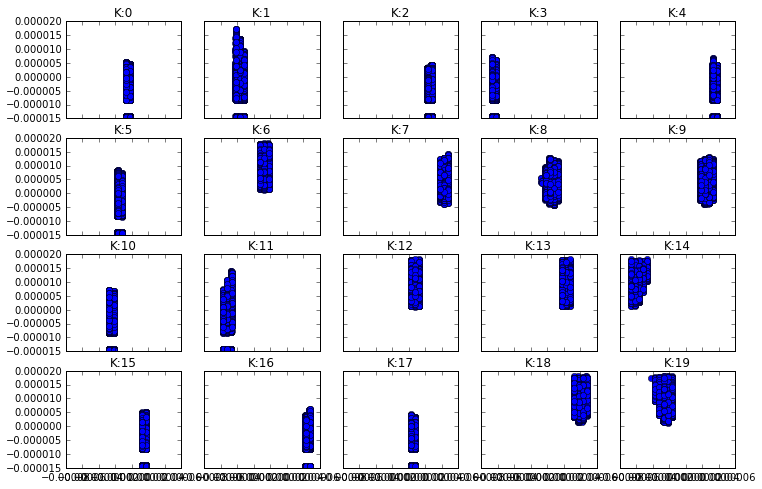

In [59]:
def plot_clusters():
    ''' Show all clusters in individual scatterplots '''
    f, axarr = plt.subplots(4, 5, sharex=True, sharey=True)
    le = MultiColumnLabelEncoder()
    nrm = Normalizer()
    imp = Imputer()
    tr = train_raw[['X','Y','TimeOfDay','YearQtr']].copy()
    pl = Pipeline([('le',le),('imp',imp),('nrm',nrm)])
    tr = pl.fit_transform(tr)
    pca = PCA(n_components=2)
    X = pca.fit_transform(tr)
    K = np.array(train_raw['KMcluster'])
    for i in range(20):
        if i<5: e=0
        elif i<10: e=1
        elif i<15: e=2
        else: e=3
        z = i - 5*e
        axarr[e, z].plot(X[K==i,0]\
                            ,X[K==i,1]\
                            ,'bo')
        axarr[e, z].set_title('K:{}'.format(i))
        plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
        plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)

plot_clusters()

In [60]:
def transform_address(x):
    x = re.sub(r'[0-9\/]','',x)
    x = x.upper()
    x = x.split()
    x = sorted(set(x))
    #removes = ['OF',' ','AV','ST','BL','CT','WY'\
    #           ,'DR','PL','RD','LN','TR','CR','TH'\
    #           ,'THE','BLOCK','HY','BLVD']
    removes = ['OF','THE','TH',' ']
    x = [ z for z in x if z not in removes ]
    x = ' '.join(x)
    x = re.sub(r'\ \ ',' ',x)
    x = re.sub(r'^\ ','',x)
    return x

transform_address = np.vectorize(transform_address)
train_raw['AddressMod'] = transform_address(train_raw['Address'])

### Part 3: Get data from other sources

SF OpenData has a ton of supplemental data sources that will be great to try out for this effort.  

NOTE: one of them is actually a list of crimes that seems to match data in the training set. I will NOT use that data to train my model or match against the test dataset; however, I believe that many contestants are doing this, given that there is a very clear separation in scores that indicates to me that maybe there is some cheating happening.

In [61]:
# http://spatialreference.org/ref/epsg/2227/
p = Proj('+proj=lcc +init=EPSG:2227 +datum=NAD83 +units=us-ft +no_defs',preserve_units=True)
convert_vals = np.vectorize(lambda x,y: p(x,y))
convert_vals_inv = np.vectorize(lambda x,y: p(x,y,inverse=True))

In [62]:
shpfilename_elect = 'Data/SanFranciscoElectricityUse/SanFranciscoElectricityUse.shp'
shpfilename_school = 'Data/schools_public_pt/schools_public_pt.shp'
shpfilename_zoning = 'Data/Zoning/Zoning_Districts.shp'
shpfilename_neighborhoods = 'Data/planning_neighborhoods/planning_neighborhoods.shp'
shpfilename_jobdensity = 'Data/SanFranciscoJobDensity/SanFranciscoJobDensity.shp'
street_tree_locations = 'Data/Street_Tree_List.csv'
report311_locations = 'Data/All_cases_map_view.csv'
business_locations = 'Data/Registered_Business_Map.csv'
park_locations = 'Data/Park_and_Open_Space_Map.csv'
offstreet_parking_locations = 'Data/Off-street_parking_lots_and_parking_garages_map.csv'
private_garage_locations = 'Data/PrivateGarages_Lots.csv'

##### Convert lat/lon to coordinates that match shape files

In [63]:
train_raw['New_X'], train_raw['New_Y'] = \
    convert_vals(train_raw['X'],train_raw['Y'])
test_raw['New_X'], test_raw['New_Y'] = \
    convert_vals(test_raw['X'],test_raw['Y'])

In [64]:
base_points = [ Point((x,y)) for x,y in zip(train_raw['New_X'],train_raw['New_Y']) ]
test_points = [ Point((x,y)) for x,y in zip(train_raw['New_X'],train_raw['New_Y']) ]
points = base_points

##### Read and process CSVs

In [65]:
trees = pd.read_csv(street_tree_locations)
report311 = pd.read_csv(report311_locations)
businesses = pd.read_csv(business_locations)
parks = pd.read_csv(park_locations, quotechar = "\"")
offstreet_parking = pd.read_csv(offstreet_parking_locations)
private_garages = pd.read_csv(private_garage_locations)

/Library/Python/2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [66]:
def getll(x):
    ''' Get lat/lon for parks file '''
    try:
        x = x.split('\n')[2]
        x = re.sub(r'[\(\)]','',x)
        x = x.split(', ')
        return float(x[0]),float(x[1])
    except AttributeError, IndexError:
        return (None,None)

parks['LatLon'] = parks['Location 1'].apply(getll)
parks['X'] = parks['LatLon'].apply(lambda x: x[1])
parks['Y'] = parks['LatLon'].apply(lambda x: x[0])

##### Read shapefiles and store properties into pandas dataframe

In [67]:
def read_jobdensity():
    ''' Process job density file into pandas dataframe '''
    shp = fiona.open(shpfilename_jobdensity)
    n = len(shp)
    TRACT2010,\
    POP2010,\
    AREA_SMI,\
    JOBS_PSMI,\
    JOBS_CNT = \
        np.empty(n,dtype='|S25'),\
        np.empty(n,dtype='|S25'),\
        np.empty(n,dtype='|S25'),\
        np.empty(n,dtype='|S25'),\
        np.empty(n,dtype='|S25')
    for i,s in enumerate(shp):
        TRACT2010[i] = s['properties']['Tract2010']
        POP2010 [i] = s['properties']['Pop2010']
        AREA_SMI [i] = s['properties']['Area_smi']
        JOBS_PSMI [i] = s['properties']['Jobs_psmi']
        JOBS_CNT [i] = s['properties']['Jobs_cnt']
    shp.close()
    props_df = pd.DataFrame({
            'Id':[i+1 for i in range(n)],
            'TRACT2010':TRACT2010,
            'POP2010':POP2010,
            'AREA_SMI':AREA_SMI,
            'JOBS_PSMI':JOBS_PSMI,
            'JOBS_CNT':JOBS_CNT
        })
    return props_df

props_df_jobs = read_jobdensity()

DEBUG:Fiona:Index: 0


In [237]:
def read_schoolfile():
    ''' Process school file into pandas dataframe '''
    shp = fiona.open(shpfilename_school)
    n = len(shp)
    SCHOOL_TYP,\
    DEPT,\
    FACILITY_N,\
    DEPTNAME,\
    FACILITY_I = \
        np.empty(n,dtype='|S25'),\
        np.empty(n,dtype='|S25'),\
        np.empty(n,dtype='|S25'),\
        np.empty(n,dtype='|S25'),\
        np.empty(n,dtype='|S25')
    for i,s in enumerate(shp):
        SCHOOL_TYP[i] = s['properties']['SCHOOL_TYP']
        DEPT [i] = s['properties']['DEPT']
        FACILITY_N [i] = s['properties']['FACILITY_N']
        DEPTNAME [i] = s['properties']['DEPTNAME']
        FACILITY_I [i] = s['properties']['FACILITY_I']
    shp.close()
    props_df = pd.DataFrame({
            'Id':[i+1 for i in range(n)],
            'SCHOOL_TYP':SCHOOL_TYP
        })
    return props_df

props_df_schools = read_schoolfile()

In [230]:
def read_zonefile():
    ''' Process zones file into pandas dataframe '''
    shp = fiona.open(shpfilename_zoning)
    n = len(shp)
    ZONING_SIM,\
    DISTRICTNA = \
        np.empty(n,dtype='|S25'),\
        np.empty(n,dtype='|S25')
    for i,s in enumerate(shp):
        ZONING_SIM[i] = s['properties']['ZONING_SIM']
        DISTRICTNA[i] = s['properties']['DISTRICTNA']
    shp.close()

    props_df_zoning = pd.DataFrame({
            'Id':[i+1 for i in range(n)],
            'ZONING_SIM':ZONING_SIM,
            'DISTRICTNA':DISTRICTNA
        })

props_df_zoning = read_zonefile()

In [228]:
def read_electfile():
    shp = fiona.open(shpfilename_elect)
    n = len(shp)
    kWh_pC,\
    kWh,\
    Zip,\
    Pop2010_zc = \
        np.empty(n,dtype=np.float64),\
        np.empty(n,dtype=np.float64),\
        np.empty(n,dtype='|S10'),\
        np.empty(n,dtype=np.int64)
    for i,s in enumerate(shp):
        kWh_pC[i] = s['properties']['kWh_pC']
        kWh [i] = s['properties']['kWh']
        Zip [i] = s['properties']['Zip']
        Pop2010_zc [i] = s['properties']['Pop2010_zc']
    shp.close()

    props_df_elect = pd.DataFrame({
            'Id':[i+1 for i in range(n)],\
            'kWh_pC':kWh_pC,\
            'kWh':kWh,\
            'Zip':Zip,\
            'Pop2010_zc':Pop2010_zc\
        })

props_df_elect = read_electfile()

In [246]:
def read_neighborhoods():
    ''' Process school file into pandas dataframe '''
    shp = fiona.open(shpfilename_neighborhoods)
    n = len(shp)
    NEIGHBORHOOD = \
        np.empty(n,dtype='|S25')
    for i,s in enumerate(shp):
        NEIGHBORHOOD[i] = s['properties']['neighborho']
    shp.close()
    props_df = pd.DataFrame({
            'Id':[i+1 for i in range(n)],
            'NEIGHBORHOOD':NEIGHBORHOOD
        })
    return props_df

neighborhoods_df = read_neighborhoods()

In [255]:
def read_sdists():
    ''' Process supervistoral district file into pandas dataframe '''
    shp = fiona.open(shpfilename_sv_districts)
    n = len(shp)
    supname = \
        np.empty(n,dtype='|S25')
    for i,s in enumerate(shp):
        supname[i] = s['properties']['supname']
    shp.close()
    props_df = pd.DataFrame({
            'Id':[i+1 for i in range(n)],
            'supname':supname
        })
    return props_df

sdist_df = read_sdists()

##### Polygon search functions

In [123]:
def polygon_search(shpfilename):
    ''' Iterate through shapefile polygons
        and find id of polgy for each datapoint
        
        Need to create these functions:
            1)a polygon match function
                (above)
            2)a run_iters function that 
                accepts a PolygonLocator object,
                a polygon match function (above),
                and a list of points to iterate over.         
    '''
    shp = pysal.open(shpfilename,'r')
    pl = PolygonLocator([p for p in shp])
    shp.close()
    return pl


##### Coordinate search functions (faster than polygon search)

In [84]:
def coord_search_centroid(shpfile, points, \
                 locator_fun=BruteForcePointLocator):
    ''' Since polygon search is not very efficient
        when there are many polygons, instead
        do a comparison to each polygon centroid 
    '''
    gather_centroids = lambda shp: [p.centroid for p in shp]

    # Read file
    shp = pysal.open(shpfile,'r')
    centroids = gather_centroids(shp)
    pl = locator_fun(centroids)
    shp.close()
    
    return pl

##### Process to find nearby schools

In [71]:
def search_schools(pts):
    ''' Find nearest point and measure distance
        for every datapoint 
    '''
    hs = props_df_schools[props_df_schools['SCHOOL_TYP']=='High School']['Id']
    cs = props_df_schools[props_df_schools['SCHOOL_TYP']=='County School']['Id']
    chs = props_df_schools[props_df_schools['SCHOOL_TYP']=='Charter School']['Id']
    ms = props_df_schools[props_df_schools['SCHOOL_TYP']=='Middle School']['Id']
    
    shp = pysal.open(shpfilename_school,'r')
    pl_hs = BruteForcePointLocator([p for p in shp if p.id in hs])
    pl_cs = BruteForcePointLocator([p for p in shp if p.id in cs])
    pl_chs = BruteForcePointLocator([p for p in shp if p.id in chs])
    pl_ms = BruteForcePointLocator([p for p in shp if p.id in ms])
    shp.close()

    return_point_hs = lambda x: pl_hs.nearest(x)
    return_point_cs = lambda x: pl_cs.nearest(x)
    return_point_chs = lambda x: pl_chs.nearest(x)
    return_point_ms = lambda x: pl_ms.nearest(x)
    
    # point_ids = np.zeros(len(points),dtype=np.int8)
    point_distances_hs = np.zeros(len(pts),dtype=np.float64)
    point_distances_cs = np.zeros(len(pts),dtype=np.float64)
    point_distances_chs = np.zeros(len(pts),dtype=np.float64)
    point_distances_ms = np.zeros(len(pts),dtype=np.float64)
    
    def run_iters():
        for i,p in enumerate(points):
            if i%100000==0: print 'running {0} row'.format(i)
            pt_hs = return_point_hs(p)
            pt_cs = return_point_cs(p)
            pt_chs = return_point_chs(p)
            pt_ms = return_point_ms(p)
            
            point_distances_hs[i] = arcdist(p,pt_hs)
            point_distances_cs[i] = arcdist(p,pt_cs)
            point_distances_chs[i] = arcdist(p,pt_chs)
            point_distances_ms[i] = arcdist(p,pt_ms)

    run_iters()
    
    return point_distances_hs,\
            point_distances_cs,\
            point_distances_chs,\
            point_distances_ms

'''            
point_distances_hs,\
            point_distances_cs,\
            point_distances_chs,\
            point_distances_ms = search_schools(points)
test_point_distances_hs,\
            test_point_distances_cs,\
            test_point_distances_chs,\
            test_point_distances_ms = search_schools(test_points)
'''

'            \npoint_distances_hs,            point_distances_cs,            point_distances_chs,            point_distances_ms = coord_search_schools(points)\ntest_point_distances_hs,            test_point_distances_cs,            test_point_distances_chs,            test_point_distances_ms = coord_search_schools(test_points)\n'

##### Functions that iterate over each observation and match GIS data points

In [72]:
def run_iters_points(points, point_locator, \
              proximity=100,log_at=100000):
    ''' Iterate through points and return number
        of points in surrounding proximity
    '''
    point_fun = lambda x,pl: pl.proximity(x,proximity)
    surrounding_pts = np.zeros(len(points),dtype=np.int64)
    for i,p in enumerate(points):
        if i%log_at==0: logger.info('running {0} row'.format(i))
        pts = point_fun(p,point_locator)
        surrounding_pts[i] = len(pts)
    return surrounding_pts

In [73]:
def run_iters_point_distance(points, point_locator\
            ,log_at=100000):
    ''' Iterate through points and return distance
        to the nearest point
    '''
    point_fun = lambda x,pl: pl.nearest(x)
    distances = np.zeros(len(points),dtype=np.int64)
    for i,p in enumerate(points):
        if i%log_at==0: logger.info('running {0} row'.format(i))
        pt = point_fun(p,point_locator)
        distances[i] = arcdist(p,pt)
    return distances

In [122]:
def run_iters_poly(points, point_locator\
                   ,log_at=100000):
    ''' Iterate through points and find matching polygon '''
    
    def return_poly_id(pl,x):
        ''' Find the polygon within the 
            PolygonLocator that 
            matches to each point
        '''
        try:
            return pl.contains_point(x)[0].id
        except IndexError:
            return -1
    
    poly_ids = np.zeros(len(points),dtype=np.int8)
    for i,p in enumerate(points):
        if i%log_at==0: logger.info('running {0} row'.format(i))
        poly_ids[i] = return_poly_id(point_locator,p)
    return poly_ids

In [79]:
def run_iters_centroid(points, point_locator, centroids, \
              log_at=1000):
    ''' Iterate through points to find 
        the nearest matching polygon centroid point
        
        Faster than running polygon search 
    '''
    point_fun = lambda x,pl: pl.nearest(x)
    id_fun = lambda p, centroids: [i for i,c in enumerate(centroids)\
                                  if c==p][0]
    nearest_ids = np.zeros(len(points),dtype=np.int64)
    for i,p in enumerate(points):
        if i%log_at==0: print 'running {0} row'.format(i)
        pt = point_fun(p,point_locator)
        pt_id = id_fun(pt, centroids)
        nearest_ids[i] = pt_id
    return nearest_ids

In [76]:
def save_file(array_to_save, colname, filename):
    ''' Write column to CSV for use later '''
    array_to_save_df = pd.DataFrame({colname:array_to_save})
    array_to_save_df.to_csv(filename)

##### Create pooling function to distribute work over many cores

In [77]:
def do_workload(worker,base_points,n_threads=2):
    n = n_threads
    pool = multiprocessing.Pool(n)
    p = [ i*len(base_points)//n for i in range(n+1) ]

    points_list = [ base_points[p[i]:p[i+1]] for i in range(n) ]
    points_list += [base_points[p[n]:]]

    res = pool.map(worker, points_list)
    pool.close()
    pool.join()
    x = pd.concat(res,axis=0)
    return x

##### Process park CSV and find if park is nearby 

In [ ]:
'''
park_points = [ Point((x,y)) for x,y in zip(trees['XCoord'],trees['YCoord']) ]
def worker(points):
    return pd.DataFrame({'trees':run_iters_point_distance(points\
                                  ,BruteForcePointLocator(park_points)\
                                  ,log_at=100000)})
x = do_workload(worker,base_points,8)
x.to_csv('Data/parks.csv')
'''
train_raw['parks'] = pd.read_csv('Data/parks.csv')

##### Process tree CSV and find number of trees nearby to crime

In [268]:
''' 
Run on another machine because it takes ~24 hours to run!
tree_points = [ Point((x,y)) for x,y in zip(trees['XCoord'],trees['YCoord']) ]

def worker(points):
    return pd.DataFrame({'trees':run_iters_points(points\
                                  ,BruteForcePointLocator(tree_points)\
                                  ,proximity=100
                                  ,log_at=1000)})

x = do_workload(worker,base_points,8)
x.to_csv('Data/trees.csv')
'''
train_raw['trees'] = pd.read_csv('Data/trees.csv')

##### Process jobs data

In [86]:
jobzone_locator = polygon_search(shpfilename_jobdensity)
def worker(points):
    return pd.DataFrame({'job_id':run_iters_poly(points\
                                    ,jobzone_locator
                                    ,log_at=1000)})
x = do_workload(worker,base_points,8)
x.to_csv('Data/job_ids.csv')

ZeroDivisionError: float division by zero

In [ ]:
'''
zone_ids = coord_search_centroid(shpfilename_zoning,base_points,\
                        run_iters_centroid)
save_file(zone_ids, 'zoning_id', 'Data/zoning_ids2.csv')

test_zone_ids = coord_search_centroid(shpfilename_zoning,test_points,\
                         run_iters_centroid)
save_file(test_zone_ids, 'zoning_id', 'Data/test_zoning_ids2.csv')
'''

##### Load data from saved files after they've already been processed

In [ ]:
# Load data fr
zone_ids = pd.read_csv('Data/zoning_ids.csv')
test_zone_ids = pd.read_csv('Data/test_zoning_ids.csv')
all_zones = pd.merge(zone_ids,props_df_zoning,'left',\
                    left_on=['zoning_id'], right_on=['Id'])
test_all_zones = pd.merge(test_zone_ids,props_df_zoning,'left',\
                    left_on=['zoning_id'], right_on=['Id'])

In [ ]:
# only run this after ids are compiled
poly_ids_df_elect = pd.read_csv('Data/poly_ids.csv')
test_poly_ids_df_elect = pd.read_csv('Data/test_poly_ids.csv')
all_elects = pd.merge(poly_ids_df_elect, props_df_elect, 'left',\
                     left_on=['elect_poly_id'], right_on=['Id'])
test_elects = pd.merge(test_poly_ids_df_elect, props_df_elect, 'left',\
                     left_on=['elect_poly_id'], right_on=['Id'])

##### Add new columns

In [ ]:
elect_cols = ['kWh_pC','kWh','Zip','Pop2010_zc']
train_raw[elect_cols] = all_elects[elect_cols] 
test_raw[elect_cols] = test_elects[elect_cols] 

In [ ]:
# School features had little/no effect on the model
# school_nearby = np.vectorize(lambda x: True if x<=1000 else False)
# train_raw['HS_DISTANCE'] = point_distances_hs.astype(np.float64)
# train_raw['CS_DISTANCE'] = point_distances_cs.astype(np.float64)
# train_raw['CHS_DISTANCE'] = point_distances_chs.astype(np.float64)
# train_raw['MS_DISTANCE'] = point_distances_ms.astype(np.float64)
# train_raw['HS_NEARBY'] = school_nearby(train_raw['HS_DISTANCE'])
# train_raw['CS_NEARBY'] = school_nearby(train_raw['CS_DISTANCE'])
# train_raw['CHS_NEARBY'] = school_nearby(train_raw['CHS_DISTANCE'])
# train_raw['MS_NEARBY'] = school_nearby(train_raw['MS_DISTANCE'])

# test_raw['HS_DISTANCE'] = test_point_distances_hs.astype(np.float64)
# test_raw['CS_DISTANCE'] = test_point_distances_cs.astype(np.float64)
# test_raw['CHS_DISTANCE'] = test_point_distances_chs.astype(np.float64)
# test_raw['MS_DISTANCE'] = test_point_distances_ms.astype(np.float64)
# test_raw['HS_NEARBY'] = school_nearby(test_raw['HS_DISTANCE'])
# test_raw['CS_NEARBY'] = school_nearby(test_raw['CS_DISTANCE'])
# test_raw['CHS_NEARBY'] = school_nearby(test_raw['CHS_DISTANCE'])
# test_raw['MS_NEARBY'] = school_nearby(test_raw['MS_DISTANCE'])

In [ ]:
train_raw['ZONING_SIM'] = all_zones['ZONING_SIM']
train_raw['DISTRICT_NAME'] = all_zones['DISTRICTNA']
train_raw['ZONE_ID'] = all_zones['Id']

test_raw['ZONING_SIM'] = test_all_zones['ZONING_SIM']
test_raw['DISTRICT_NAME'] = test_all_zones['DISTRICTNA']
test_raw['ZONE_ID'] = test_all_zones['Id']

In [249]:
new_fields = [
    'PdDistrict','DaySegment','DayOfWeek','AddressMod'\
    ,'DayOfMonth','YearQtr','KMcluster','KMdistance','trees'
]
cat_fields = [
    'PdDistrict','YearQtr','Year','DayOfWeek','DaySegment','TimeOfDay'\
    ,'DayOfMonth','YearSegment','KMcluster','AddressMod'\
    ,'collar_id','Category'
]

In [ ]:
def add_knnguess():
    knn = KNeighborsClassifier(n_neighbors=20)
    le = MultiColumnLabelEncoder()
    imp = Imputer(strategy='mean')
    cf = [i for i,x in enumerate(new_fields) if x in cat_fields]
    ohe = OneHotEncoder(categorical_features=cf,sparse=True)
    svd = TruncatedSVD(n_components=20) 
    pl = Pipeline([('le',le),('ohe',ohe),('svd',svd),('md',md)])
    
    pl.fit(dev_train, dev_train_labels)
    train_raw['KNNguess'] = pl.predict(train_raw[new_fields])
    test_raw['KNNguess'] = pl.predict(test_raw[new_fields])

add_knnguess()

In [259]:
def predict_metaclass():
    '''Predict the metaclass of crime
       Use the outputted algorithm to 
       predict metaclass in the training data
    '''
    logger.info('Sampling started')
    
    '''Alternate sampling method
    tr = sample_df(train_raw[new_fields+['collar_id','Category']]\
                                    ,'Category'\
                                     ,set(train_raw['Category'])\
                                      ,group_n=200000\
                                       ,group_cnts=group_cnts\
                                         ,nX=20)
    
    '''
    tr = train_raw[new_fields+['collar_id','Category']].copy().iloc[\
                   np.random.permutation(len(train_raw))]
    
    dev_train, dev_train_labels = tr[new_fields][10001:],\
                           tr['collar_id'][10001:]
    dev_test, dev_test_labels = tr[new_fields][:10000],\
                            tr['collar_id'][:10000]
    
    # Create pipeline
    le = MultiColumnLabelEncoder()
    cf = [i for i,x in enumerate(new_fields) if x in cat_fields]
    ohe = OneHotEncoder(categorical_features=cf,sparse=True)
    imp = Imputer()
    ''' Alternative classifiers
    md = OneVsRestClassifier(MultinomialNB(alpha=0.01))'''
    md = LogisticRegression(C=0.1,solver='lbfgs',\
                            multi_class='multinomial',tol=0.01)
    svd = TruncatedSVD(n_components=20) 
    pl = Pipeline([('le',le),('ohe',ohe),('imp',imp),('svd',svd),('md',md)])
    
    ''' GridSearch for optimal parameters
    logger.info('GV search started')
    param_grid = dict(md__C=[0.1,0.5,1,5])
    gs = GridSearchCV(pl, param_grid=param_grid, verbose=10)
    gs.fit(dev_train, dev_train_labels)
    logger.info('Best C parameter: {}'.format(gs.best_estimator_)) 
    logger.info('GV search ended')
    '''
    
    # Fit training data 
    logger.info('Fitting training data') 
    pl.fit(dev_train, dev_train_labels)
    
    # Show results
    print 'Model accuracy: {}%'.format(round(pl.score(dev_test, \
                                                 dev_test_labels),4)*100)
    logger.info('Model diagnostics started')
    predictions = pl.predict(dev_test)
    conf = confusion_matrix(dev_test_labels,predictions)
    plt.imshow(conf, cmap='binary',interpolation='nearest')
    print pd.crosstab(dev_test_labels, predictions, \
                      rownames=['True'], colnames=['Predicted'], \
                      margins=True)
    
    # Return model and datasets for later use
    return pl, (dev_train,dev_train_labels,dev_test,dev_test_labels)

logger.info('Model for collar_id started')
pl_metaclass, new_datasets = predict_metaclass()
logger.info('Model for collar_id ended')

INFO:root:Model for collar_id started
INFO:root:Sampling started
INFO:root:Fitting training data


ValueError: bad input shape (868048, 9)

In [ ]:
dev_train,dev_train_labels,dev_test,dev_test_labels = new_datasets
print 'F1 Score: {}%'.format(round(f1_score(\
                    pl_metaclass.predict(dev_test)\
                    ,dev_test_labels\
                    ,average='weighted')*100,2))
print classification_report(pl_metaclass.predict(dev_test)\
                    ,dev_test_labels)

##### Add prediction and prediction score as a feature

Use the generated dev and test datasets from above in future modeling efforts, because otherwise the model will have been fit with test data and accuracy measures will have been thrown off.

In [ ]:
new_fields = [
        'PdDistrict','DaySegment','DayOfWeek','AddressMod'\
        ,'DayOfMonth','Year','YearSegment'\
        ,'KMcluster','KMdistance'
    ]
le,ohe,md = [ x[1] for x in pl_metaclass.steps[:3] ]
tr = le.transform(train_raw[new_fields])
tr = ohe.transform(tr)
train_raw['cid_pred_score'] = \
    #np.max(md.decision_function(tr),axis=1)
    np.max(md.predict_proba(tr),axis=1)
train_raw['cid_prediction'] = pl_metaclass.predict(tr) # overfit
 
tr = le.transform(test_raw[new_fields])
tr = ohe.transform(tr)
test_raw['cid_pred_score'] = \
    #np.max(md.decision_function(tr),axis=1)
    np.max(md.predict_proba(tr),axis=1)
test_raw['cid_prediction'] = pl_metaclass.predict(tr)

##### Test performance

In [ ]:
new_fields = [
    'PdDistrict','DaySegment',\
    'kWh','Zip','Pop2010_zc','Year','KMcluster'
]
cat_fields = [
    'PdDistrict','DayOfWeek','DaySegment','TimeOfDay','DayOfMonth','Year',\
    'Zip','KMcluster',\
    'ZONING_SIM','DISTRICT_NAME','ZONE_ID'
]
train_raw = train_raw.iloc[\
                    np.random.permutation(len(train_raw))]
dev_train, dev_train_labels = train_raw[new_fields][10001:],\
                        train_raw['Category'][10001:]
dev_train_weights = np.array(train_raw['sample_weight'][10001:])
dev_test, dev_test_labels = train_raw[new_fields][:10000],\
                        train_raw['Category'][:10000]

In [ ]:
def runmodel():
    new_fields = [
        'PdDistrict','DaySegment',\
        'kWh','Zip','Pop2010_zc','Year','KMcluster'
    ]
    cat_fields = [
        'PdDistrict','DayOfWeek','DaySegment','TimeOfDay','DayOfMonth','Year',\
        'Zip','KMcluster',\
        'ZONING_SIM','DISTRICT_NAME','ZONE_ID','KNNguess'
    ]

    le = MultiColumnLabelEncoder()
    imp = Imputer(strategy='mean')
    cf = [i for i,x in enumerate(new_fields) if x in cat_fields]
    ohe = OneHotEncoder(categorical_features=cf,sparse=True)
    pca = PCA(n_components = 100)
    #md = MultinomialNB(alpha=0.01)
    md = LogisticRegression(C=0.1,solver='lbfgs',\
                            multi_class='multinomial')
    pl = Pipeline([('le',le), ('imp',imp), ('ohe', ohe), ('pca',pca), ('rf', rf)])

    pl.fit(dev_train, dev_train_labels,rf__sample_weight=dev_train_weights)
    print 'Accuracy: {0}%'.format(round(pl.score(dev_test, dev_test_labels),4)*100)
    return pl 

# pl = runmodel()

In [ ]:
def show_pca():
    exp_var = np.cumsum(pl.named_steps['pca'].explained_variance_ratio_)
    n = len(exp_var)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title('PCA explained variance')
    ax.set_xlabel('Feature number')
    ax.set_ylabel('Explained Variance')
    ax.plot(range(n),exp_var,'-', linewidth=2)

    plt.show()

# show_pca()

##### Make another submission

In [ ]:
def save_testdata():
    test_raw.to_csv('Data/test_raw_nf.csv',index=False)

# save_testdata()

In [ ]:
# predictions = pl.predict(test_raw[new_fields])

In [ ]:
def write_to_submissionfile():
    l = len(test_raw)
    submission = np.zeros((l,40),dtype=np.int32)
    submission[:,0] = range(l)
    cols = sorted(set(train_raw['Category']))
    for i,c in enumerate(cols):
        submission[:,i+1] = predictions == c

    submission_cols = ['Id']
    submission_cols.extend(cols)
    submission_df = pd.DataFrame(submission,columns=submission_cols)
    submission_df.head()

    submission_df.to_csv('Data/submission_file2.csv',index=False)
    
# write_to_submissionfile()

#### Part 3 - Error Diagnosis

In [ ]:
predictions = pl.predict(dev_test)
conf = confusion_matrix(dev_test_labels,predictions)
plt.imshow(conf, cmap='binary')
pd.crosstab(dev_test_labels, predictions, rownames=['True'], colnames=['Predicted'], margins=True)

#### Appendix: Cheaters

Virtually all of the test dataset is available publicly online, with a holdout of only ~70k records. My thoughts are that the competition conductors will test using data from the holdout set (or else they are very silly).

In [41]:
test_raw_clean = test_raw.drop_duplicates()
crimes = pd.read_csv('/Users/bshur/School/\
Machine Learning/Final Project/Data/\
SFPD_Incidents_-_from_1_January_2003.csv')
crimes['Dates'] = pd.to_datetime(crimes['Date']\
                                 +' '\
                                 +crimes['Time']\
                                 ,format='%m/%d/%Y %H:%M')
crimes_cleaned = crimes[['Dates','DayOfWeek'\
                         ,'PdDistrict','Address'\
                         ,'X','Y']].drop_duplicates()
crimes_matched = pd.merge(crimes_cleaned\
                          ,test_raw_clean\
                          ,how='inner'
                          ,on=['Dates','DayOfWeek'\
                               ,'PdDistrict','Address'\
                               ,'X','Y'])

In [45]:
print 'Test set count: {}\nMatched set count: {}\nDifference: {}'.format(\
                            test_raw_clean.shape[0]\
                            ,crimes_matched.shape[0]\
                            ,test_raw_clean.shape[0]\
                              -crimes_matched.shape[0])

Test set count: 884262
Matched set count: 815740
Difference: 68522
